In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import razdel
import nltk
import re
import string

from nltk.tokenize import word_tokenize, TweetTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from pymorphy2 import MorphAnalyzer
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm_notebook
from collections import Counter, defaultdict

from emoji import UNICODE_EMOJI

import warnings 
warnings.simplefilter("ignore")

In [245]:
train = pd.read_csv('~/2021-homework3-texts/train.csv', engine='python', index_col='id', sep=';')
test = pd.read_csv('~/2021-homework3-texts/test.csv', engine='python', index_col='id', sep=';')

In [47]:
train.label.value_counts(normalize=True)

1    0.446079
2    0.361901
0    0.192020
Name: label, dtype: float64

## Разведочный анализ

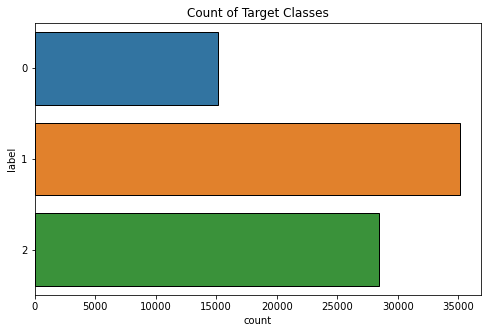

In [258]:
plt.figure(figsize=(8,5))
plt.title("Count of Target Classes")
sns.countplot(y=train["label"], linewidth=1, edgecolor='black')

plt.show()

### Длины сообщений

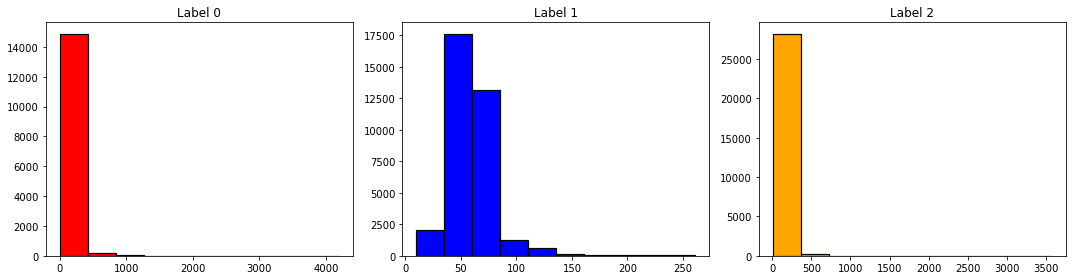

In [264]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
colors = iter(('red','blue','orange'))

for i in range(len(ax)):
    char_len = train[train['label'] == i]['text'].str.len()
    ax[i].hist(char_len, color=next(colors), edgecolor='black', linewidth=1.2)
    ax[i].set_title(f'Label {i}')

plt.tight_layout()
plt.show()

Категории 0 и 2 имеют практически идентичное распределение.

### Длины слов

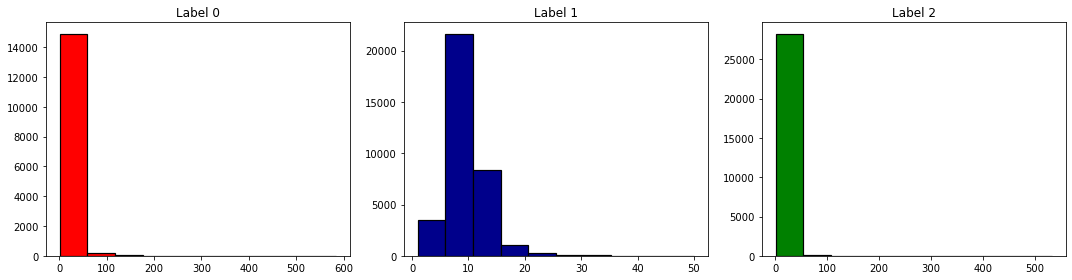

In [272]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
colors = iter(('red','darkblue','green'))

for i in range(len(ax)):
    words_len = train[train['label'] == i]['text'].str.split().map(lambda x: len(x))
    ax[i].hist(words_len, color=next(colors), edgecolor='black', linewidth=1.2)
    ax[i].set_title(f'Label {i}')

plt.tight_layout()
plt.show()

Снова видим сходство в категориях 0 и 2.

### Анализ слов и пунктуации

In [4]:
def create_corpus(target):
    corpus = []
    for x in train[train['label'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

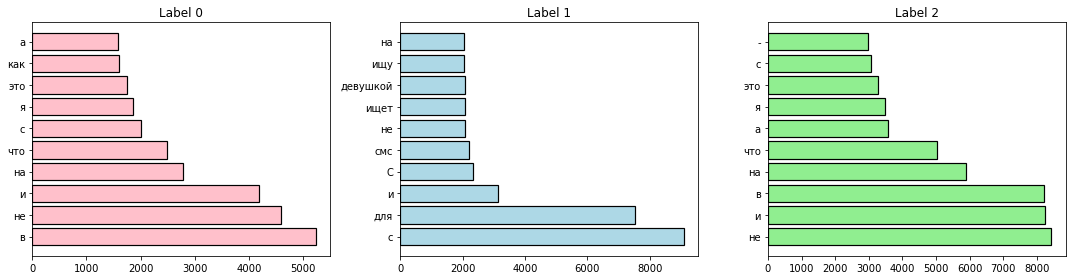

In [280]:
def analyze_stopwords(data, func, target):
    values_list = []
    for label in range(len(target)):
        corpus = func(target[label])
        dic = Counter(corpus)
        top = dic.most_common(10)
        x_items, y_values = zip(*top)
        values_list.append((x_items, y_values))
    
    fig, ax = plt.subplots(1, 3, figsize=(15,4))
    colors = iter(('pink','lightblue','lightgreen'))
    values_list
    for i in range(len(ax)):
        word_counts = train[train['label'] == i]['text'].str.split().map(lambda x: len(x))
        ax[i].barh(values_list[i][0], values_list[i][1], color=next(colors), edgecolor='black', linewidth=1.2)
        ax[i].set_title(f'Label {i}')

    plt.tight_layout()
    plt.show()

analyze_stopwords(train, create_corpus, [0, 1, 2])

Значимых различий в частотном распределении первой 20-ки слов в группах 0 и 2 не наблюдается. Самые популярные слова — из категории стандартных стоп-слов.

В 1-й группе сразу заметны якоря:
 - искать
 - девушка
 - смс

#### Пунктуация

In [46]:
def analyze_punctuation(data, func, target):
    values_list = []
    special = string.punctuation
    for label in range(len(target)):
        dic = defaultdict(int)
        corpus = func(target[label])
        for i in corpus:
            if i in special:
                dic[i]+=1
        x_items,y_values = zip(*dic.items())
        values_list.append((x_items, y_values))
    fig, ax = plt.subplots(1, 3, figsize=(15,4))
    colors = iter(('pink','lightblue','lightgreen'))

    for i in range(len(ax)):
        specials = train[train['label'] == i]['text'].str.split().map(lambda x: len(x))
        ax[i].bar(values_list[i][0], values_list[i][1], color=next(colors), edgecolor='black', linewidth=1.2)
        ax[i].set_title(f'Label {i}')

    plt.tight_layout()
    plt.show()

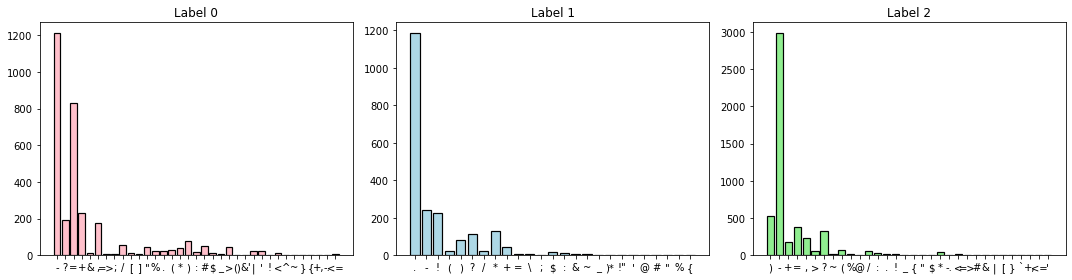

In [47]:
analyze_punctuation(train, create_corpus, [0, 1, 2])

Видим, что в группе 0 чаще, чем во 2-й используется знак «=». Запомним это.

#### Эмодзи

In [109]:
for i in range(3):
    print(f'{i} =>', sum(Counter(train.query(f'label == {i}')['text'] \
            .apply(lambda x: ''.join([y for y in x if y in UNICODE_EMOJI['en'].keys()])).str.cat()).values()))

0 => 301
1 => 0
2 => 723


Видим, что в текстах 1-й группы отсутствуют любые эмодзи, хотя в отсальных они достаточно популярны. Во второй группе они встречаются вдвое чаще.

Сохраним эмодзи из второй группы в отдельный список. Попробуем сохранить их для анализа.

In [33]:
true_emoji = train.query(f'label == 2')['text'] \
            .apply(lambda x: ''.join([y for y in x if y in UNICODE_EMOJI['en'].keys()])).str.cat()

## Предобработка данных

In [26]:
tqdm_notebook.pandas()

def prepare_data(data):
    #STOPWORDS = stopwords.words('russian')
    # r_tokenizer = RegexpTokenizer('\w+')
    morph = MorphAnalyzer()
    
    review = data.lower()
    # review = re.sub(r'https?://\S+|www\.\S+|http?://\S+', ' ', review) # remove urls
    # review = re.sub(r'<.*?>', ' ', review) # remove html tags
    review = re.sub(r'=', ' eq ', review) # keep '='
    review = ' '.join(UNICODE_EMOJI['en'].get(x) if x in true_emoji else x for x in review.split())
    review = re.sub(r'[^\w]', ' ', review)
    review = [token.text for token in razdel.tokenize(review)]
    review = [morph.parse(token)[0].normal_form for token in review]
    # review = [token for token in review if token not in STOPWORDS]
    review = [token for token in review if not token.isdigit()]
    review = re.sub(r'\b_+\b', '', ' '.join(review))
    
    return review

После первых попыток было решено отказаться от удаления ссылок, и стоп-слов, так как часть данных содержит только их. Знак = кодируем в eq, эмодзи — в их буквенное представление.

In [191]:
train["clean"] = train["text"].progress_apply(prepare_data)

In [248]:
test["clean"] = test["text"].progress_apply(prepare_data)

Посчитаем общие слова для категорий 0 и 2

In [343]:
counter_0 = Counter(train[train.label == 0]["clean"].str.cat().split())
counter_2 = Counter(train[train.label == 2]["clean"].str.cat().split())

In [290]:
len((counter_0 & counter_2).keys()) # общие слова

2779

Очень много общих слов, представляющих собой важные признаки для обеих категорий.

In [344]:
(counter_0 & counter_2).most_common(50)

[('это', 1863),
 ('eq', 1115),
 ('всё', 1011),
 ('мочь', 782),
 ('который', 769),
 ('просто', 459),
 ('весь', 451),
 ('делать', 428),
 ('работать', 421),
 ('ещё', 377),
 ('сделать', 373),
 ('хороший', 334),
 ('писать', 305),
 ('вопрос', 293),
 ('свой', 284),
 ('знать', 282),
 ('хотеть', 282),
 ('дать', 277),
 ('d', 261),
 ('работа', 251),
 ('должный', 249),
 ('написать', 248),
 ('вообще', 243),
 ('задача', 233),
 ('первый', 221),
 ('нужно', 216),
 ('тип', 211),
 ('большой', 210),
 ('очень', 205),
 ('каждый', 204),
 ('человек', 200),
 ('com', 196),
 ('использовать', 195),
 ('найти', 190),
 ('x', 190),
 ('понять', 188),
 ('b', 187),
 ('разный', 183),
 ('время', 183),
 ('почему', 182),
 ('нужный', 173),
 ('код', 172),
 ('простой', 164),
 ('a', 164),
 ('c', 162),
 ('второй', 160),
 ('случай', 159),
 ('новый', 159),
 ('r', 157),
 ('значение', 148)]

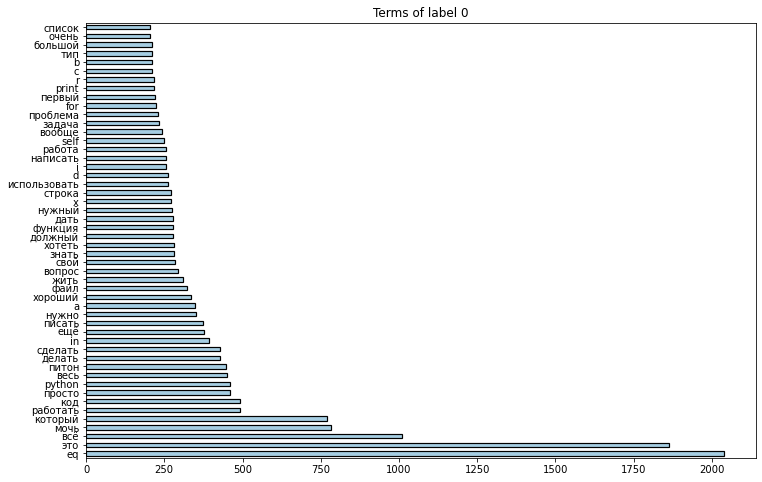

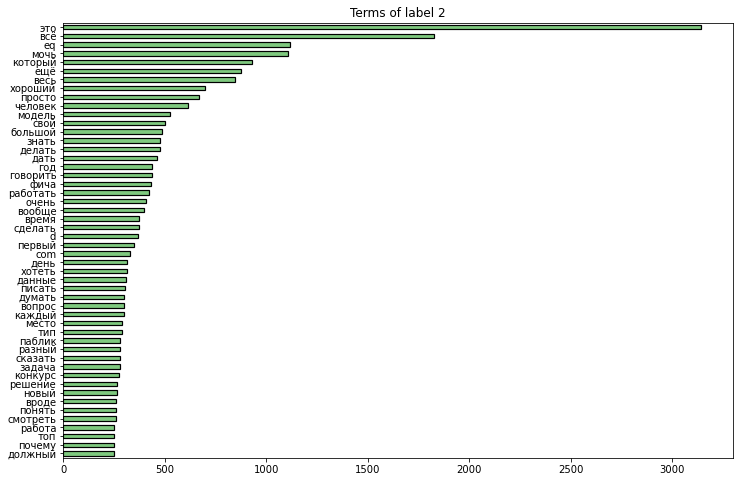

In [383]:
colors = iter(['Paired', 'Accent'])
splited_data = [counter_0, counter_2]
labels = [0, 2]

for label, data in zip(labels, splited_data):
    plt.figure(figsize=(12,8))
    plt.title(f'Terms of label {label}', fontsize=12)
 
    pd.Series(data).sort_values(ascending=False) \
        .head(50).plot(kind='barh', fontsize=10, colormap=next(colors), edgecolor='black', linewidth=1.2)
    if label == 2:
        plt.gca().invert_yaxis()
    plt.show()

Первая пятерка слов повторяется в обеих группах.

Попробуем удалить некоторые их них.

In [279]:
common_words = ['это', 'всё', 'мочь', 'который', 'ещё', 'весь', 'просто', 'cвой', 'хороший']

def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)

train.loc[train.label == 0, "clean"] = train.loc[train.label == 0, "clean"].apply(text_cleaning)
train.loc[train.label == 2, "clean"] = train.loc[train.label == 2, "clean"].apply(text_cleaning)

In [288]:
test["clean"] = test["clean"].apply(text_cleaning)

## Моделирование

#### Тренировочная выборка

In [373]:
X_train, X_test, y_train, y_test = train_test_split(train.clean, train.label, test_size=0.25, random_state=42)

#### Векторайзер TF-IDF

Наряду с короткими сообщениями в датасете есть и длинные тексты.

In [220]:
tfidf_vectorizer = TfidfVectorizer(min_df=2)

In [422]:
# def viz_coeffs(model, feature_names, n_features=25):
#     coef = model.coef_.ravel()
#     pos_coef = np.argsort(coef)[-n_features:]
#     neg_coef = np.argsort(coef)[:n_features]
#     all_coef = np.hstack([neg_coef, pos_coef])
    
#     plt.figure(figsize=(15,5))
#     colors = np.where(coef[all_coef] < 0, 'pink', 'lightblue')
#     plt.bar(np.arange(2*n_features), coef[all_coef], color=colors, edgecolor='black')
#     feature_names = np.array(feature_names)
#     plt.xticks(np.arange(1, 1 + 2*n_features), feature_names[all_coef], rotation=60, ha='right')

In [377]:
X_test.shape

(19682,)

In [411]:
train_vectors = tfidf_vectorizer.fit_transform(X)
test_vectors = tfidf_vectorizer.transform(X_test)

#### Шкалирование признаков

In [355]:
scaler = MaxAbsScaler()
train_vectors_maxscaled = scaler.fit_transform(train_vectors)
test_vectors_maxscaled = scaler.transform(test_vectors)

### Базовая модель

Для базовой модели возьмем мультиноминальную байесовскую модель.

In [412]:
multinomial_nb = MultinomialNB(alpha=.7)
multinomial_nb.fit(train_vectors, y_train)
labels = multinomial_nb.predict(test_vectors)

print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           0       0.90      0.66      0.76      3753
           1       0.97      0.99      0.98      8746
           2       0.84      0.94      0.88      7183

    accuracy                           0.91     19682
   macro avg       0.90      0.86      0.88     19682
weighted avg       0.91      0.91      0.90     19682



In [237]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_heatmap(true, predicted):
    classes = true.unique()
    matrix = confusion_matrix(true, predicted, labels=classes)
    sns.heatmap(matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt='g')

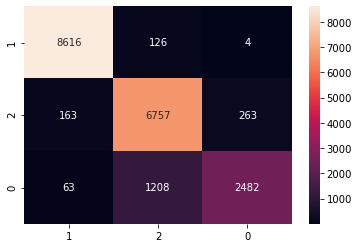

In [424]:
plot_confusion_matrix_heatmap(y_test, labels)

В нулевой группе больше всего неточнойстей предсказаний. Но в целом качество неплохое.

### Логистическая регрессия

Попробуем сразу предсказать категории для наших тестовых данных.

In [356]:
logreg = Pipeline([('vec', tfidf_vectorizer),
                   ('scaler', MaxAbsScaler()),
                   ('clf', LogisticRegression(max_iter=1000, solver='sag',
                                              multi_class='multinomial', random_state=42, C=10))
                  ])

logreg.fit(train.clean, train.label)
predicts = logreg.predict(test.clean)
pd.Series(predicts, index=test.index).to_csv('submit.csv')

### Векторизация word2vec

Вероятнее всего с word2vec качество предсказаний было бы лучше, но ресурсов компьютера не хватило чтобы получить векторную модель.

In [553]:
import io
import gzip
import pathlib
import urllib.request

WORD2VEC_PATH = pathlib.Path('word2vec.bin')

if not WORD2VEC_PATH.exists():
    url = 'https://rusvectores.org/static/models/rusvectores2/news_mystem_skipgram_1000_20_2015.bin.gz'
    with urllib.request.urlopen(url) as connection:
        compressed = connection.read()
            
    decompressed = gzip.GzipFile(fileobj=io.BytesIO(compressed), mode='rb').read()
    WORD2VEC_PATH.write_bytes(decompressed)

In [554]:
import numpy as np
from sklearn.base import TransformerMixin


class Word2VecVectorizer(TransformerMixin):
    def __init__(self, vectors):
        self.vectors = vectors
        self.zeros = np.zeros(self.vectors.vector_size)
        
    def _get_text_vector(self, text):
        token_vectors = []
        for token in tokenize_with_mystem_pos(text):
            try:
                token_vectors.append(self.vectors[token])
            except KeyError: # не нашли такой токен в словаре
                pass
                
        if not token_vectors:
            return self.zeros

        text_vector = np.sum(token_vectors, axis=0)
        return text_vector / np.linalg.norm(text_vector)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([self._get_text_vector(text) for text in X])

In [555]:
from gensim.models import KeyedVectors

word2vec = KeyedVectors.load_word2vec_format(WORD2VEC_PATH, binary=True)

In [578]:
word2vec.most_similar(positive=['язык_S'], negative=['обучение_S'])

[('диалект_S', 0.28100141882896423),
 ('по-русски_ADV', 0.2706732153892517),
 ('русский_A', 0.2578692138195038),
 ('наречие_S', 0.25665023922920227),
 ('иврит_S', 0.24834367632865906),
 ('изъясняться_V', 0.23711204528808594),
 ('иноязычный_A', 0.2351139485836029),
 ('идиш_S', 0.23013189435005188),
 ('латынь_S', 0.22875937819480896),
 ('фарси_S', 0.22835373878479004)]

In [560]:
from pymystem3 import Mystem

mystem = Mystem()

word2vec_mystem = Mystem(entire_input=False)


def tokenize_with_mystem_pos(text):
    result = []
    
    for item in word2vec_mystem.analyze(text):
        if item['analysis']:
            lemma = item['analysis'][0]['lex']
            pos = re.split('[=,]', item['analysis'][0]['gr'])[0]
            token = f'{lemma}_{pos}'
        else:
            token = f'{item["text"]}_UNKN'
            
        result.append(token)

    return result

In [561]:
from sklearn.base import TransformerMixin


class Word2VecVectorizer(TransformerMixin):
    def __init__(self, vectors):
        self.vectors = vectors
        self.zeros = np.zeros(self.vectors.vector_size)
        
    def _get_text_vector(self, text):
        token_vectors = []
        for token in tokenize_with_mystem_pos(text):
            try:
                token_vectors.append(self.vectors[token])
            except KeyError: # не нашли такой токен в словаре
                pass
                
        if not token_vectors:
            return self.zeros

        text_vector = np.sum(token_vectors, axis=0)
        return text_vector / np.linalg.norm(text_vector)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([self._get_text_vector(text) for text in X])

In [570]:
pymorphy = MorphAnalyzer()

def lemmatize_with_pymorphy(tokens):
    lemms = [pymorphy.parse(token)[0].normal_form for token in tokens]
    return lemms

In [574]:
X_train, X_test, y_train, y_test = train_test_split(train.clean, train.label, test_size=0.25, random_state=42)

word2vec_vectorizer = Word2VecVectorizer(word2vec)

tfidf_vectorizer = TfidfVectorizer(
    min_df=2, 
    tokenizer=lambda text: lemmatize_with_pymorphy(tokenize_with_razdel(text)),
)

In [575]:
from sklearn.pipeline import FeatureUnion


tfidf_w2v = FeatureUnion(
        [
            ('tf-idf', tfidf_vectorizer),
            ('word2vec', word2vec_vectorizer),
        ]
    )

In [577]:
train_vectors_union = tfidf_w2v.fit_transform(X_train)
test_vectors_union = tfidf_w2v.transform(X_test)

BrokenPipeError: [Errno 32] Broken pipe